"""Columns Understanding 
Type: consisting of a letter L, M, or H for low, medium and high as product quality variants.

air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K.

process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise.

torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.

tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

machine failure: whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes

tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 ~ 240 mins.

heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air and process temperature is below 8.6 K and the rotational speed is below 1380 rpm

power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails.

overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain.

random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters."""


In [ ]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sklearn.metrics as sk_metrics
from sklearn.preprocessing import LabelEncoder, Normalizer, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier


In [ ]:
current_directory=os.path.dirname(os.path.abspath("machine_failure_predictions_classic_model.ipynb"))
if os.name=="nt":
    current_directory=current_directory[0].upper()+current_directory[1:]
  
current_directory = current_directory.split(os.sep)

# Remove the unwanted part (e.g., 'Projects')
current_directory = [part for part in current_directory if part != 'notebooks']

# Reconstruct the path
current_directory = os.sep.join(current_directory)
train_path=os.path.join(current_directory,r"src\datasets\machine_failure\train.csv")
train_path


train_path=r"{}".format(train_path)


def replace_slashes(path, to_forward=True):
    if to_forward:
        return path.replace("\\", "/")
    else:
        return path.replace("/", "\\")
if os.name=="nt":
    train_path = replace_slashes(train_path, to_forward=True)


train_data = pd.read_csv(train_path)


In [ ]:
train_data

In [ ]:

non_numeric_columns = train_data.select_dtypes(include=['object']).columns

# Apply Label Encoding to these columns
label_encoder = LabelEncoder()
for column in non_numeric_columns:
    train_data[column] = label_encoder.fit_transform(train_data[column])


In [ ]:
sns.countplot(x="Machine failure", data=train_data)

In [ ]:
train_data

In [ ]:
train_data_failed=train_data[train_data['Machine failure']==1]
train_data_failed

In [ ]:
num_samples=train_data_failed['Machine failure'].count()


In [ ]:
train_data_notfailed=train_data[train_data['Machine failure']==0]
train_data_notfailed_balanced = train_data_notfailed.sample(n=num_samples, random_state=42)

train_data_notfailed_balanced

In [ ]:
balanced_train_data = pd.concat([train_data_notfailed_balanced, train_data_failed])
balanced_train_data

In [ ]:
balanced_train_data = balanced_train_data.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_train_data

In [ ]:
sns.countplot(x="Machine failure", data=balanced_train_data)

In [ ]:
y=balanced_train_data['Machine failure']
x=balanced_train_data.drop(['Machine failure','Product ID','Type'],axis=1)
x

In [ ]:
y

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1,test_size=0.3)

In [31]:

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_classifier.fit(x_train, y_train)

# Predict and evaluate
y_pred = rf_classifier.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9014740108611327


Confusion Matrix:
[[621  38]
 [ 89 541]]


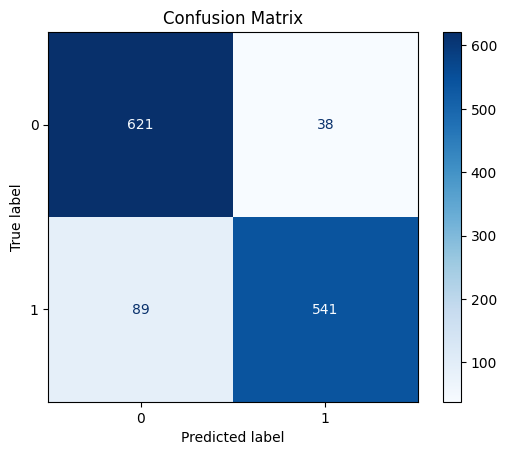

In [32]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
valdation_data=train_data.sample(n=100000, random_state=42)
valdation_data

In [ ]:
y_valdation=valdation_data['Machine failure']
x_valdiation=valdation_data.drop(['Machine failure','Product ID','Type'],axis=1)
x_valdiation

In [ ]:
y_valdation

In [ ]:
y_pred = rf_classifier.predict(x_valdiation)
print("Accuracy:", accuracy_score(y_valdation, y_pred))


In [ ]:
conf_matrix = confusion_matrix(y_valdation, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()